# Agriculture Crop Yield: Predict Fertilizer Use

By: Jaeyoung Oh

GitHub: https://github.com/BlueJayVRStudio/CSCA5632_final



##### dataset: https://www.kaggle.com/datasets/samuelotiattakorah/agriculture-crop-yield

The author of the dataset also posted a preliminary EDA. We will use this as a reference and adjust it to the needs of this project

##### EDA reference: https://www.kaggle.com/code/samuelotiattakorah/eda-on-agriculture-crop-yield

## Initial Project Setup

In [531]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

In [532]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Iterative Data Cleaning and EDA

In [537]:
num_tests = 5
tests_passed = 0

In [538]:
# import data
df_crop_yield = pd.read_csv('./data/crop_yield.csv')

### Data Description

In [539]:
df_crop_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


There are **no null values**, so conveniently we do not have to fill in any missing values. However, we still have numerous preprocessing steps to ensure that our data is ready for clustering tasks.
> - Separate "Fertilizer_Used" from rest of the data frame since we'll be using that as target class,
> - "Region", "Soil_Type" and "Crop" are non-ordinal categorical data, thus we need to convert them to binary, one-hot encoding,
> - "Weather_Condition" is also categorical, but one could argue that it is ordinal since cloud cover is directly proportional to sunlight and precipitation. Using just one of those two relationships should suffice,
> - For the rest of the numerical columns, we will perform quick outlier analysis and drop them as we have sufficient data. We will also ensure that no column has over-influence by using standard scaling,
> - Random sample portion of the dataset, since we will run into memory issues with 1 million data points,
> - Lastly we will check for class imbalance on fertilizer use to ensure that we are working with a balanced sample dataset.

In [540]:
df_crop_yield.head(10)

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251
5,South,Silt,Soybean,797.471182,37.704974,False,True,Rainy,74,5.898416
6,West,Clay,Wheat,357.902357,31.593431,False,False,Rainy,90,2.652392
7,South,Sandy,Rice,441.131154,30.887107,True,True,Sunny,61,5.829542
8,North,Silt,Wheat,181.587861,26.752729,True,False,Sunny,127,2.943716
9,West,Sandy,Wheat,395.048968,17.646199,False,True,Rainy,140,3.707293


In [541]:
# Sanity Check 1: Check unprocessed crop yield dataframe shape
assert df_crop_yield.shape == (1000000, 10), f"expected (1000000, 10), but got {df_crop_yield.shape}"
tests_passed += 1
print ("1. Tests Passed")

1. Tests Passed


### One-hot encode Region, Soil Type, and Crop

In [542]:
df_crop_yield = pd.get_dummies(df_crop_yield, columns =['Region', 'Soil_Type', 'Crop'])
# confirm one-hot encoding for region and crop 
df_crop_yield

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
0,897.077239,27.676966,False,True,Cloudy,122,6.555816,False,False,False,...,False,False,True,False,False,True,False,False,False,False
1,992.673282,18.026142,True,True,Rainy,140,8.527341,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,147.998025,29.794042,False,False,Sunny,106,1.127443,False,True,False,...,True,False,False,False,True,False,False,False,False,False
3,986.866331,16.644190,False,True,Rainy,146,6.517573,False,True,False,...,False,False,True,False,False,False,False,False,True,False
4,730.379174,31.620687,True,True,Cloudy,110,7.248251,False,False,True,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,302.805345,27.987428,False,False,Sunny,76,1.347586,False,False,False,...,False,False,False,True,False,False,False,True,False,False
999996,932.991383,39.661039,True,False,Rainy,93,7.311594,False,False,True,...,False,False,False,False,True,False,False,False,False,False
999997,867.362046,24.370042,True,False,Cloudy,108,5.763182,False,True,False,...,False,True,False,False,False,True,False,False,False,False
999998,492.812857,33.045505,False,False,Sunny,102,2.070159,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [543]:
# Sanity Check 2: Check one-hot encoded crop yield dataframe shape
assert df_crop_yield.shape == (1000000, 23), f"expected (1000000, 23), but got {df_crop_yield.shape}"
tests_passed += 1
print ("2. Tests Passed")

2. Tests Passed


### Convert Weather Condition to Ordinal Ranking

In [544]:
print(df_crop_yield.Weather_Condition.unique())

['Cloudy' 'Rainy' 'Sunny']


In [545]:
weather_ranking = {'Rainy': 0, 'Cloudy': 1, 'Sunny': 2}

In [546]:
df_crop_yield['Weather_Condition'] = df_crop_yield['Weather_Condition'].map(weather_ranking)

In [547]:
# Sanity Check 3: Repeat previous checks and check data type of weather condition
assert df_crop_yield.shape == (1000000, 23 ), f"expected (1000000, 23 ), but got {df_crop_yield.shape}"
assert df_crop_yield.Weather_Condition.dtype == np.int64, "Weather condition not converted to ordinal ranking"
tests_passed += 1
print ("3. Tests Passed")

3. Tests Passed


### Outlier Analysis and Miscellaneous Cleaning on Numerical Data

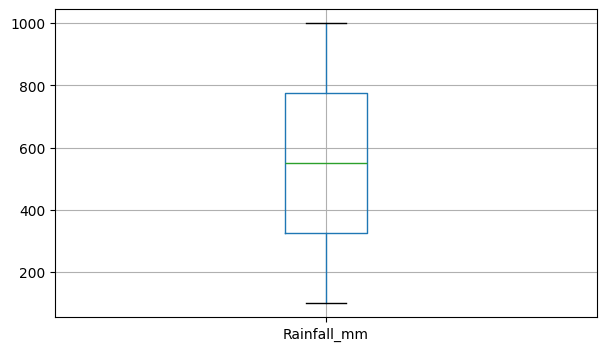

In [548]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Rainfall_mm']].boxplot()
plt.xticks(rotation=0)
plt.show()

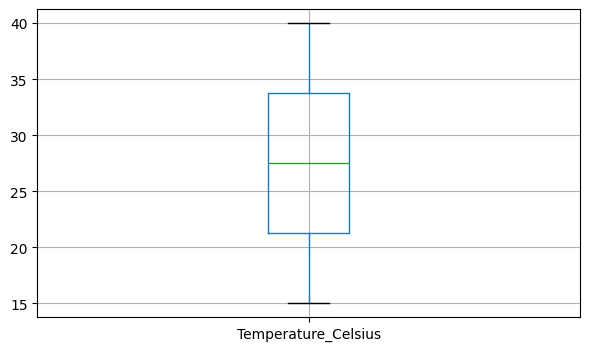

In [549]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Temperature_Celsius']].boxplot()
plt.xticks(rotation=0)
plt.show()

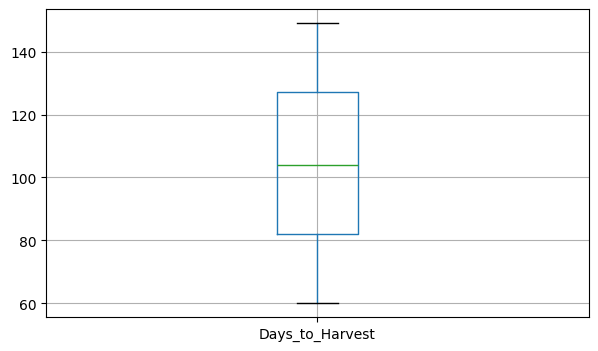

In [550]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Days_to_Harvest']].boxplot()
plt.xticks(rotation=0)
plt.show()

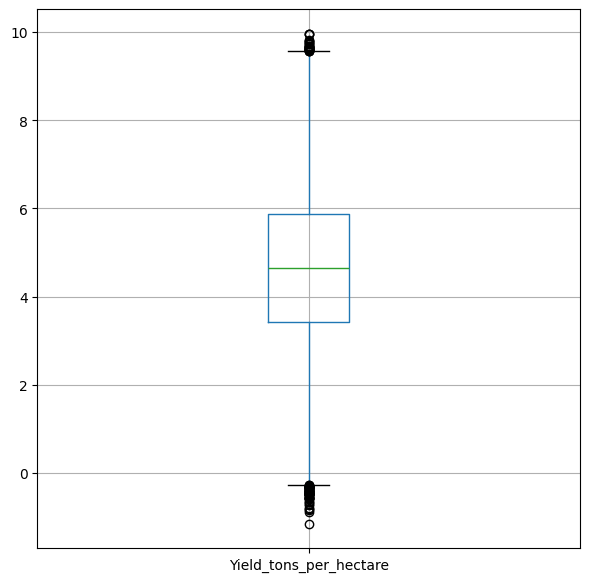

In [551]:
plt.figure(figsize=(7, 7))
df_crop_yield[['Yield_tons_per_hectare']].boxplot()
plt.xticks(rotation=0)
plt.show()

In [552]:
Q1 = df_crop_yield['Yield_tons_per_hectare'].quantile(0.25)
Q3 = df_crop_yield['Yield_tons_per_hectare'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < lower_bound) | (df_crop_yield['Yield_tons_per_hectare'] > upper_bound)]
outliers

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
11596,957.380991,36.324216,True,True,2,73,9.727004,False,False,False,...,False,True,False,False,False,False,False,False,False,True
39669,147.755191,20.390486,False,False,1,72,-0.469229,True,False,False,...,True,False,False,False,True,False,False,False,False,False
54745,119.136310,15.984143,False,False,1,93,-0.290180,False,True,False,...,False,True,False,False,True,False,False,False,False,False
77504,120.422223,22.809881,False,False,0,120,-0.841617,False,False,False,...,False,False,True,False,False,False,False,False,False,True
93760,108.811480,17.936402,False,False,0,88,-0.434482,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942403,987.281001,23.821032,True,True,0,114,9.826285,False,False,True,...,False,False,False,True,False,False,True,False,False,False
947118,110.727929,23.191667,False,False,0,80,-0.507013,False,True,False,...,False,False,False,False,False,True,False,False,False,False
949892,107.476604,15.473496,False,False,2,80,-0.309650,False,True,False,...,False,False,False,True,False,False,False,False,True,False
966078,948.730680,38.383078,True,True,1,82,9.650875,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [553]:
negatives = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < 0)]
negatives

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
756,101.019421,33.804131,False,False,0,117,-0.007103,True,False,False,...,False,True,False,False,False,True,False,False,False,False
7799,108.804894,18.004082,False,False,2,86,-0.061283,False,False,True,...,False,False,False,False,False,False,False,True,False,False
8421,168.120735,38.473430,False,False,1,111,-0.119911,True,False,False,...,False,False,False,False,False,False,False,False,True,False
9553,156.607973,16.610257,False,False,2,129,-0.193093,False,True,False,...,False,False,False,True,False,False,False,False,False,True
15435,177.481344,27.719742,False,False,2,94,-0.009811,False,False,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975666,116.114046,16.257818,False,False,2,70,-0.471038,False,False,True,...,False,False,False,False,True,False,False,False,False,False
982738,235.792353,31.699429,False,False,2,68,-0.255772,False,False,False,...,True,False,False,False,False,False,False,False,False,True
987054,100.467398,15.735951,False,False,0,96,-0.120282,False,False,False,...,False,True,False,False,True,False,False,False,False,False
995837,105.575189,15.864764,False,False,0,111,-0.051633,True,False,False,...,False,False,False,False,False,False,True,False,False,False


Rainfall, temperature and days-to-harvest are all within normal ranges, and thus do not require processing besides scaling. Yield in tons per hectare, on the other hand, has 84 outliers and 231 negative numbers, some of which are subset of the outliers. We will drop the outliers and negative numbers sequentially.

In [554]:
df_crop_yield = df_crop_yield.drop(outliers.index)
df_crop_yield.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999916 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall_mm             999916 non-null  float64
 1   Temperature_Celsius     999916 non-null  float64
 2   Fertilizer_Used         999916 non-null  bool   
 3   Irrigation_Used         999916 non-null  bool   
 4   Weather_Condition       999916 non-null  int64  
 5   Days_to_Harvest         999916 non-null  int64  
 6   Yield_tons_per_hectare  999916 non-null  float64
 7   Region_East             999916 non-null  bool   
 8   Region_North            999916 non-null  bool   
 9   Region_South            999916 non-null  bool   
 10  Region_West             999916 non-null  bool   
 11  Soil_Type_Chalky        999916 non-null  bool   
 12  Soil_Type_Clay          999916 non-null  bool   
 13  Soil_Type_Loam          999916 non-null  bool   
 14  Soil_Type_Peaty         9

In [555]:
negatives = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < 0)]
df_crop_yield = df_crop_yield.drop(negatives.index)
df_crop_yield.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999741 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall_mm             999741 non-null  float64
 1   Temperature_Celsius     999741 non-null  float64
 2   Fertilizer_Used         999741 non-null  bool   
 3   Irrigation_Used         999741 non-null  bool   
 4   Weather_Condition       999741 non-null  int64  
 5   Days_to_Harvest         999741 non-null  int64  
 6   Yield_tons_per_hectare  999741 non-null  float64
 7   Region_East             999741 non-null  bool   
 8   Region_North            999741 non-null  bool   
 9   Region_South            999741 non-null  bool   
 10  Region_West             999741 non-null  bool   
 11  Soil_Type_Chalky        999741 non-null  bool   
 12  Soil_Type_Clay          999741 non-null  bool   
 13  Soil_Type_Loam          999741 non-null  bool   
 14  Soil_Type_Peaty         9

In [556]:
# Sanity Check 4: Check final shape of crop yield dataframe
assert df_crop_yield.shape == (999741, 23), f"expected (999741, 23), but got {df_crop_yield.shape}"
tests_passed += 1
print ("4. Tests Passed")

4. Tests Passed


### Standard Scaling Numerical Columns

In [557]:
columns_to_scale = ['Rainfall_mm','Temperature_Celsius','Days_to_Harvest','Yield_tons_per_hectare']
scaler = StandardScaler()
df_crop_yield[columns_to_scale] = scaler.fit_transform(df_crop_yield[columns_to_scale])

df_crop_yield

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
0,1.335693,0.023691,False,True,1,0.674483,1.124123,False,False,False,...,False,False,True,False,False,True,False,False,False,False
1,1.703656,-1.312907,True,True,0,1.368039,2.287279,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,-1.547616,0.316897,False,False,2,0.057989,-2.078496,False,True,False,...,True,False,False,False,True,False,False,False,False,False
3,1.681304,-1.504301,False,True,0,1.599225,1.101561,False,True,False,...,False,False,True,False,False,False,False,False,True,False
4,0.694050,0.569880,True,True,1,0.212113,1.532645,False,False,True,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.951741,0.066689,False,False,2,-1.097938,-1.948617,False,False,False,...,False,False,False,True,False,False,False,True,False,False
999996,1.473932,1.683434,True,False,0,-0.442913,1.570016,False,False,True,...,False,False,False,False,True,False,False,False,False,False
999997,1.221315,-0.434304,True,False,1,0.135051,0.656487,False,True,False,...,False,True,False,False,False,True,False,False,False,False
999998,-0.220376,0.767211,False,False,2,-0.096135,-1.522315,False,False,False,...,False,False,False,True,False,False,False,False,False,True


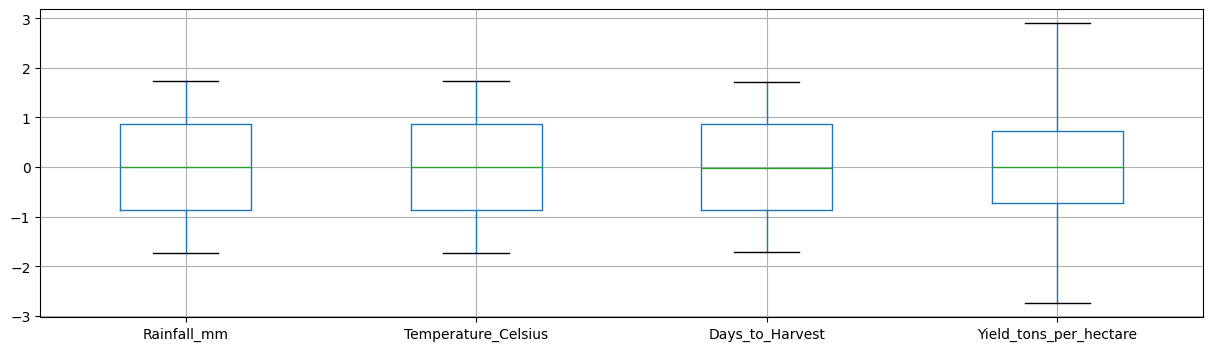

In [558]:
plt.figure(figsize=(15, 4))
df_crop_yield[['Rainfall_mm','Temperature_Celsius','Days_to_Harvest','Yield_tons_per_hectare']].boxplot()
plt.xticks(rotation=0)
plt.show()

### Random Sample and Balance Labels

In [559]:
df_crop_yield = df_crop_yield.sample(10000, random_state=0)
df_crop_yield

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
593580,1.449689,-0.390803,True,False,1,1.676287,1.121534,False,True,False,...,False,True,False,False,False,False,True,False,False,False
117093,1.092327,-0.519511,True,True,1,1.136854,1.330045,False,False,False,...,False,False,True,False,False,False,True,False,False,False
98606,-1.533938,0.527083,False,True,0,0.790076,-0.940151,False,True,False,...,True,False,False,False,True,False,False,False,False,False
351283,-1.190772,0.694750,True,True,1,1.599225,-0.462174,False,False,True,...,False,False,True,False,False,True,False,False,False,False
549053,-0.881264,0.227503,False,True,2,-1.213530,-0.765631,True,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801832,-1.451299,0.590864,True,False,1,0.982730,-1.379818,True,False,False,...,True,False,False,False,False,False,False,True,False,False
512102,0.749366,1.707244,True,True,0,-1.020876,1.233683,False,True,False,...,False,True,False,False,True,False,False,False,False,False
645103,1.355379,-0.825615,True,True,0,0.212113,1.905300,False,False,True,...,False,True,False,False,False,True,False,False,False,False
47371,0.292874,-1.595899,False,False,1,1.175385,-0.575480,False,True,False,...,False,True,False,False,False,False,False,True,False,False


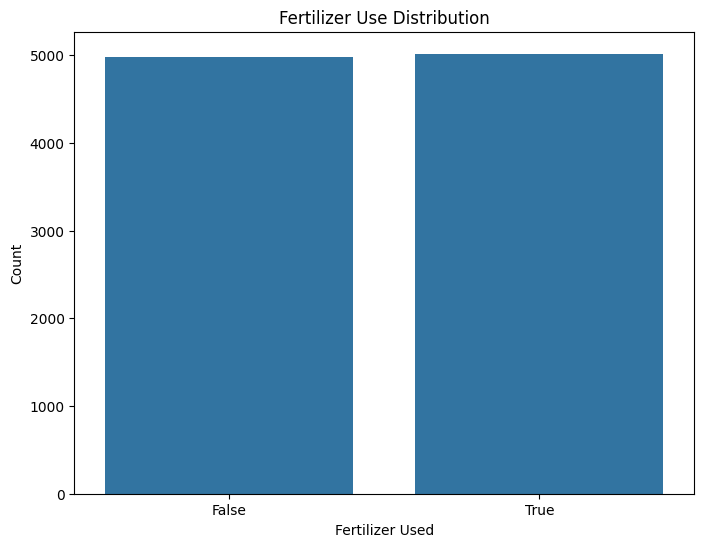

In [560]:
class_counts = df_crop_yield.Fertilizer_Used.value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Fertilizer Use Distribution')
plt.xlabel('Fertilizer Used')
plt.ylabel('Count')
plt.show()

Target labels are fairly balanced, so we will leave it as is.

### Separate Target Labels

In [561]:
df_labels = df_crop_yield.Fertilizer_Used
df_crop_yield = df_crop_yield.drop(columns=['Fertilizer_Used'])

In [562]:
df_labels

593580     True
117093     True
98606     False
351283     True
549053    False
          ...  
801832     True
512102     True
645103     True
47371     False
313273    False
Name: Fertilizer_Used, Length: 10000, dtype: bool

In [563]:
# confirm labels were extracted and print unique target labels
print(sorted(df_labels.unique()))

[np.False_, np.True_]


In [565]:
# confirm that labels have been dropped
df_crop_yield

,Rainfall_mm,Temperature_Celsius,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,Region_West,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
593580,1.449689,-0.390803,False,1,1.676287,1.121534,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False
117093,1.092327,-0.519511,True,1,1.136854,1.330045,False,False,False,True,...,False,False,True,False,False,False,True,False,False,False
98606,-1.533938,0.527083,True,0,0.790076,-0.940151,False,True,False,False,...,True,False,False,False,True,False,False,False,False,False
351283,-1.190772,0.694750,True,1,1.599225,-0.462174,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
549053,-0.881264,0.227503,True,2,-1.213530,-0.765631,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801832,-1.451299,0.590864,False,1,0.982730,-1.379818,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
512102,0.749366,1.707244,True,0,-1.020876,1.233683,False,True,False,False,...,False,True,False,False,True,False,False,False,False,False
645103,1.355379,-0.825615,True,0,0.212113,1.905300,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
47371,0.292874,-1.595899,False,1,1.175385,-0.575480,False,True,False,False,...,False,True,False,False,False,False,False,True,False,False


In [566]:
# Sanity Check 5: Check labels shape and (-)labels crop yield dataframe shape
assert df_labels.shape == (10000,), f"expected (10000,), but got {df_labels.shape}"
assert df_crop_yield.shape == (10000, 22), f"expected (10000, 22), but got {df_crop_yield.shape}"
tests_passed += 1
print ("5. Tests Passed")

5. Tests Passed


### Data Cleaning and EDA Conclusion

## Model Building and Training

### Split Data for Train and Validation Sets

Since we have a dense dataset, we will use a 70-30 train-validation split  

In [528]:
X_train, X_test, y_train, y_test =  train_test_split(df_crop_yield, df_labels, test_size=0.3, random_state=42)

### Hierarchical Clustering

In [45]:
# model=AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
# model.fit(sample_crop_yield.iloc[:, 8:])
# print(model.labels_[0:20])

[0 3 5 3 0 0 1 1 3 3 5 2 3 0 1 5 1 2 2 2]


### Non-negative Matrix Factorization

### Linear Kernel SVC

In [529]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

parameters = {'loss': ['hinge', 'squared_hinge'],
              'C':np.logspace(-2, 0, 301, base=2)}
svc = LinearSVC(random_state=1)
grid_linsvc = GridSearchCV(svc, parameters, cv=5, n_jobs=-1, scoring='accuracy')

grid_linsvc.fit(X_train, y_train)

best_params = grid_linsvc.best_params_
best_score = grid_linsvc.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score}")

best params: {'C': np.float64(0.5743491774985175), 'loss': 'hinge'}
cross validation score: 0.9295714285714286


In [530]:
from sklearn.metrics import confusion_matrix
from helpers.metrics import *

def handle_stats(predictor, model_name):
    
    # Predict validation set
    prediction = predictor.predict(X_test)
    test_labels = np.array(y_test)
    
    print(f"Prediction: {prediction} \n")
    print(f"True Label: {test_labels} \n")
    
    # Calculate Accuracy
    total = len(np.array(prediction == test_labels))
    correct = len(np.where(np.array(prediction == test_labels) == True)[0])
    accuracy = correct/total
    
    # Construct confusion matrix
    confusion_mat = confusion_matrix(test_labels, prediction)
    
    # Calculate Precision
    _precision = precision(confusion_mat)
    # Calculate Recall
    _recall = recall(confusion_mat)
    
    print(confusion_mat)
    print(f"accuracy: {accuracy}")
    print(f"precision: {_precision}")
    print(f"recall: {_recall}")

handle_stats(grid_linsvc.best_estimator_, 'Linear SVC')

Prediction: [ True  True  True ... False  True  True] 

True Label: [ True  True  True ... False  True False] 

[[1379   99]
 [  83 1439]]
accuracy: 0.9393333333333334
precision: 0.9394295716895644
recall: 0.9392420413991276


In [ ]:
assert tests_passed == num_tests, f"{tests_passed} out of {num_tests} tests passed. {num_tests-tests_passed} cases failed. Please check test cases."
print("All Tests Passed")